<a href="https://colab.research.google.com/github/likhi02-hue/c_dst_may2025/blob/main/Day_6assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Evaluation Metrics

Confusion Matrix:
[[2266  434]
 [  73  227]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.84      0.90      2700
       Fraud       0.34      0.76      0.47       300

    accuracy                           0.83      3000
   macro avg       0.66      0.80      0.69      3000
weighted avg       0.91      0.83      0.86      3000


Accuracy: 0.8310


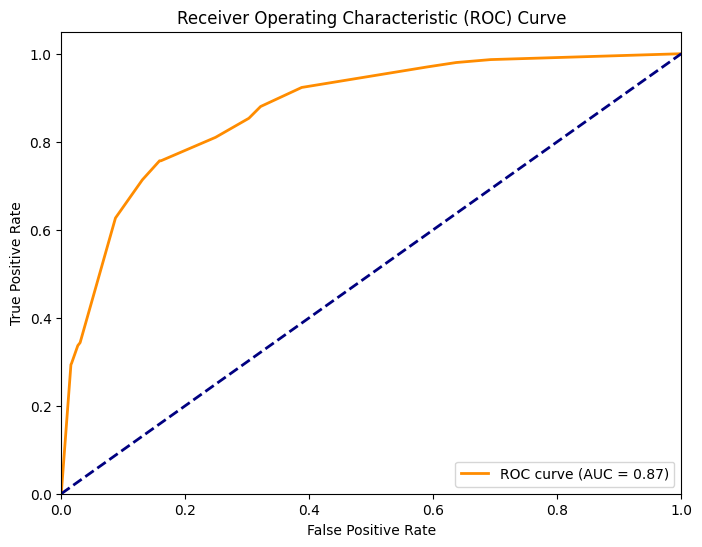

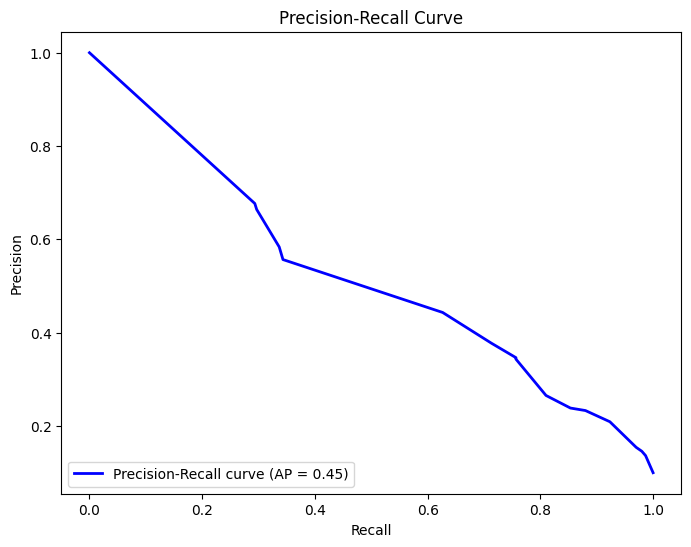


K-Fold Cross Validation Results
Accuracy: 0.789 (±0.043)
Precision: 0.295 (±0.034)
Recall: 0.759 (±0.060)
F1: 0.422 (±0.029)
Roc_auc: 0.856 (±0.009)

Feature Importances
Feature 0: 0.7888
Feature 1: 0.0000
Feature 2: 0.0000
Feature 3: 0.2084
Feature 4: 0.0028


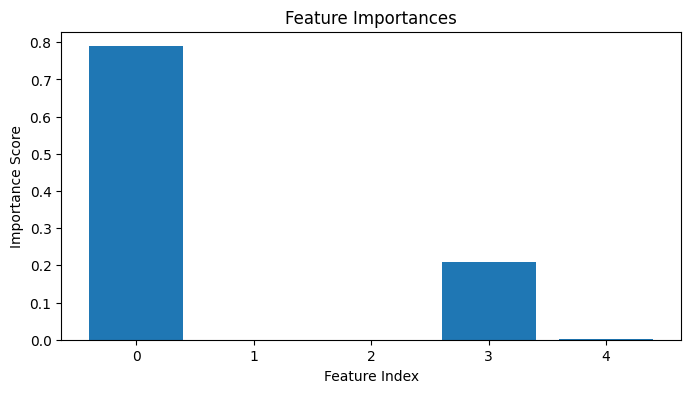

In [1]:

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                            roc_curve, auc, precision_recall_curve,
                            average_precision_score, accuracy_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset (replace with your dataset)
# For demonstration, we'll create a synthetic credit card fraud dataset
def load_data():
    # Create synthetic data (10000 samples, 10% fraud cases)
    n_samples = 10000
    n_features = 5

    # Generate random features
    X = np.random.randn(n_samples, n_features)

    # Create binary labels (1=fraud, 0=normal)
    y = np.zeros(n_samples)
    fraud_indices = np.random.choice(n_samples, size=int(n_samples*0.1), replace=False)
    y[fraud_indices] = 1

    # Make some features more important for fraud detection
    X[:, 0] = X[:, 0] + y * 1.5  # Feature 0 has stronger correlation with fraud
    X[:, 3] = X[:, 3] + y * 0.8  # Feature 3 has moderate correlation

    return X, y

# Load and prepare data
X, y = load_data()

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

# Handle class imbalance by upsampling the minority class
def upsample_minority(X_train, y_train):
    # Combine features and labels
    train_data = np.column_stack((X_train, y_train))

    # Separate classes
    majority = train_data[train_data[:, -1] == 0]
    minority = train_data[train_data[:, -1] == 1]

    # Upsample minority class
    minority_upsampled = resample(minority,
                                replace=True,
                                n_samples=len(majority),
                                random_state=42)

    # Combine back
    upsampled = np.vstack((majority, minority_upsampled))

    # Shuffle the data
    np.random.shuffle(upsampled)

    # Split back into X and y
    X_train_up = upsampled[:, :-1]
    y_train_up = upsampled[:, -1]

    return X_train_up, y_train_up

X_train_up, y_train_up = upsample_minority(X_train, y_train)

# Standardize features (important for some metrics like ROC AUC)
scaler = StandardScaler()
X_train_up = scaler.fit_transform(X_train_up)
X_test = scaler.transform(X_test)

# Initialize Decision Tree classifier
dt_classifier = DecisionTreeClassifier(
    max_depth=4,               # Limit tree depth
    min_samples_split=20,      # Minimum samples to split a node
    min_samples_leaf=10,       # Minimum samples at a leaf node
    class_weight='balanced',   # Adjust weights for imbalanced classes
    random_state=42
)

# Train the model
dt_classifier.fit(X_train_up, y_train_up)

# Make predictions
y_pred = dt_classifier.predict(X_test)
y_prob = dt_classifier.predict_proba(X_test)[:, 1]  # Probabilities for positive class

# Evaluation metrics
print("="*50)
print("Model Evaluation Metrics")
print("="*50)

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# K-Fold Cross Validation
print("\n" + "="*50)
print("K-Fold Cross Validation Results")
print("="*50)

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
for metric_name, metric in scoring.items():
    scores = cross_val_score(dt_classifier, X, y, cv=kf, scoring=metric)
    print(f"{metric_name.capitalize()}: {scores.mean():.3f} (±{scores.std():.3f})")

# Feature Importance
print("\n" + "="*50)
print("Feature Importances")
print("="*50)

if hasattr(dt_classifier, 'feature_importances_'):
    importances = dt_classifier.feature_importances_
    for i, imp in enumerate(importances):
        print(f"Feature {i}: {imp:.4f}")

    # Plot feature importances
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(importances)), importances)
    plt.title('Feature Importances')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance Score')
    plt.show()